In [1]:
rm(list = ls())
set.seed(1234)
options(future.seed = TRUE)
Sys.setenv(RETICULATE_PYTHON = "/home/gonglihao/miniconda3/envs/42/bin/python")
suppressPackageStartupMessages({
    library("dplyr")
    library("Matrix")
    library("Seurat")
    library("future.apply")
    library("tictoc")
    library("ggplot2")
    library("ggpubr")
    library("future")
    library("COSG")
    library("harmony")
    library("parallel")
    library("patchwork")
})

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
combined <- readRDS("/data3/Group8/gonglihao/1-MMP9/2-Harmony/combined-0.6.rds")

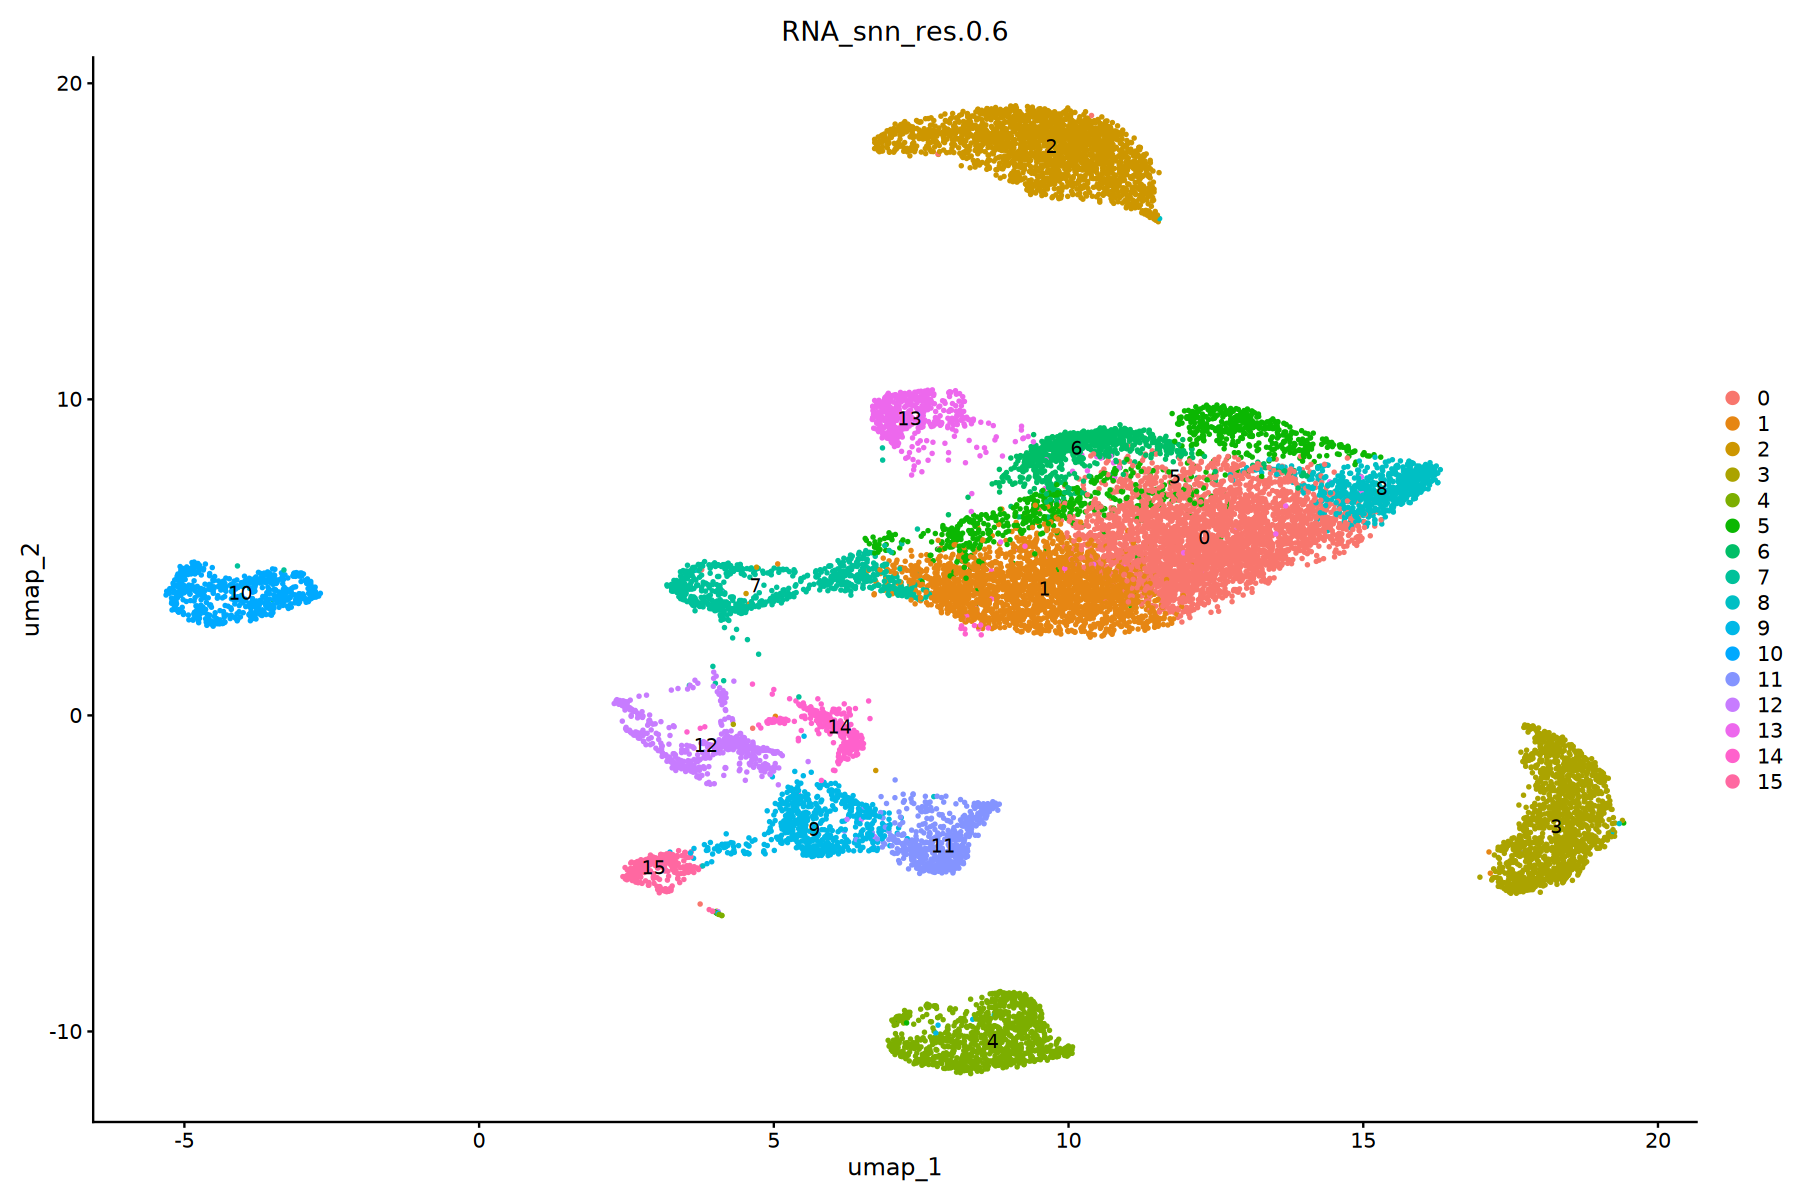

In [2]:
options(repr.plot.width = 15, repr.plot.height = 10)
DimPlot(combined,
        reduction = "umap",
        group.by = "RNA_snn_res.0.6",
        label = TRUE,
        label.size = 4,
        pt.size = 0.5)

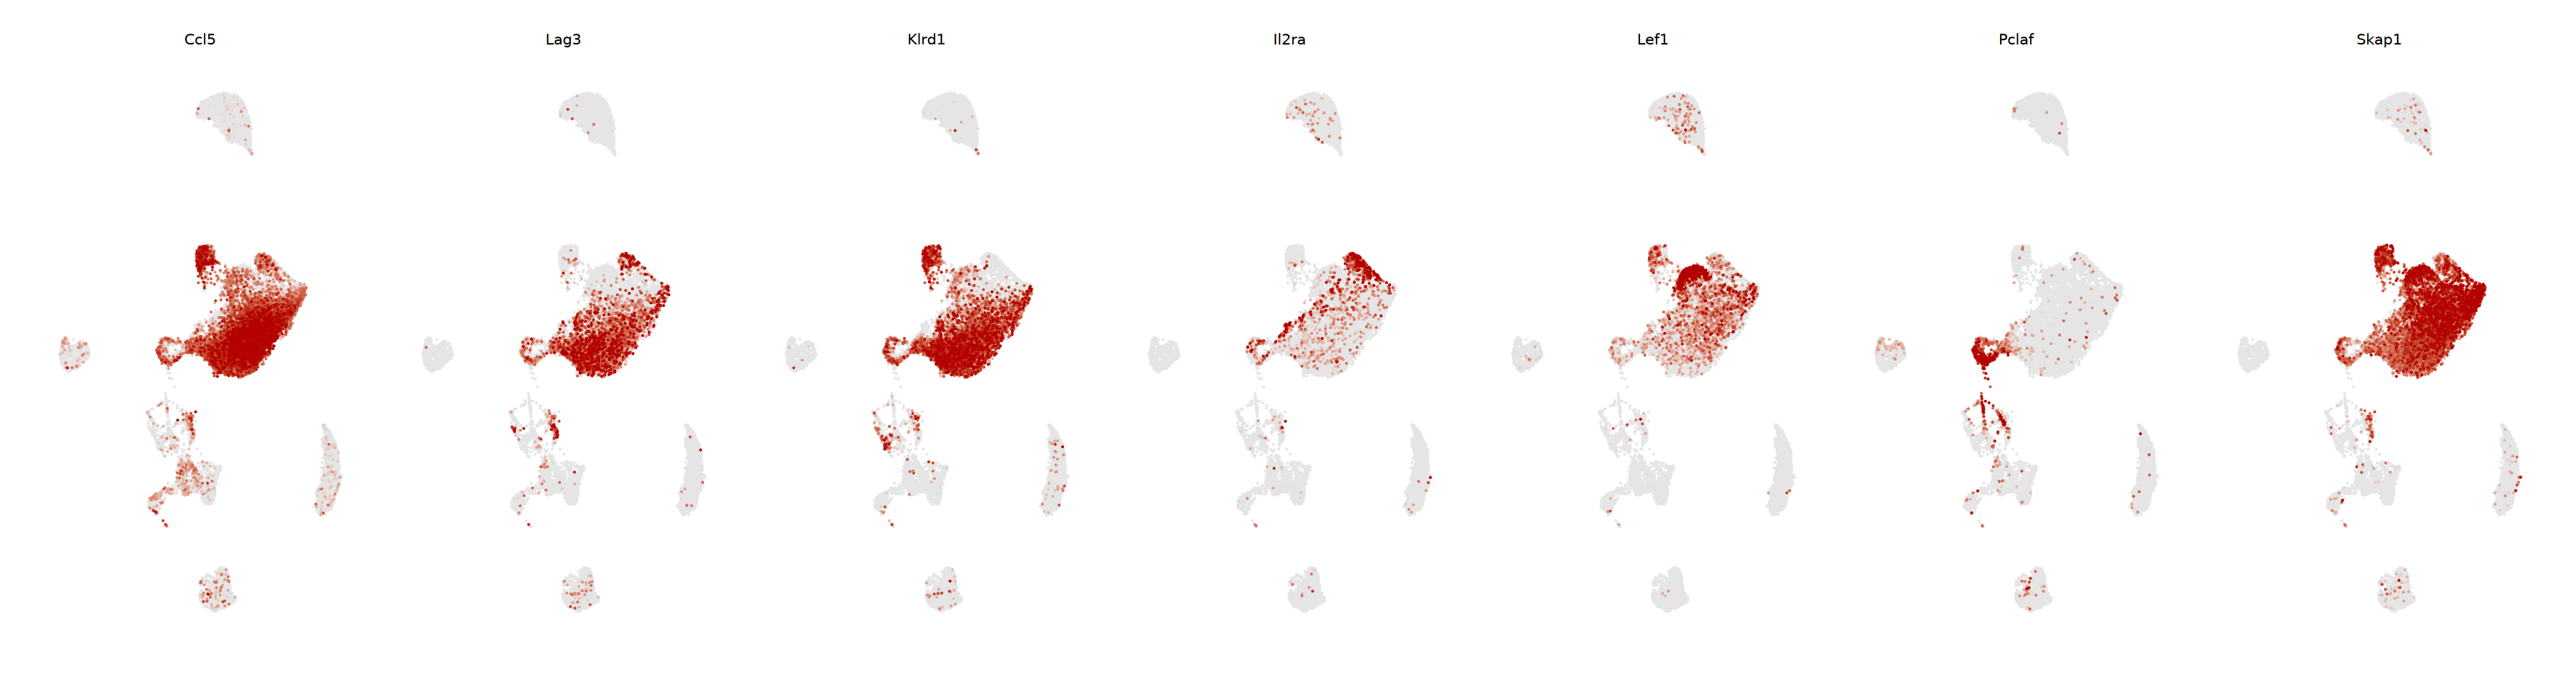

In [6]:
# 设置图形大小
options(repr.plot.width = 30, repr.plot.height = 8)

# 创建FeaturePlot
FeaturePlot(combined,
    features = c( "Ccl5", "Lag3", "Klrd1","Il2ra","Lef1", "Pclaf","Skap1"),
    ncol = 7,
    pt.size = 0.1,
    order = TRUE,
    reduction = "umap",
    cols = c("grey90", "#B30000"),
    min.cutoff = "q10",
    max.cutoff = "q90"
) &
theme_minimal() &
theme(
    plot.title = element_text(size = 12, face = "bold", hjust = 0.5),  # 标题居中
    strip.text = element_text(size = 12, face = "bold", hjust = 0.5),  # 分面标题居中
    axis.title = element_blank(),    # 移除轴标题
    axis.text = element_blank(),     # 移除轴文本
    axis.ticks = element_blank(),    # 移除轴刻度线
    legend.position = "none",        # 移除图例
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm")
)

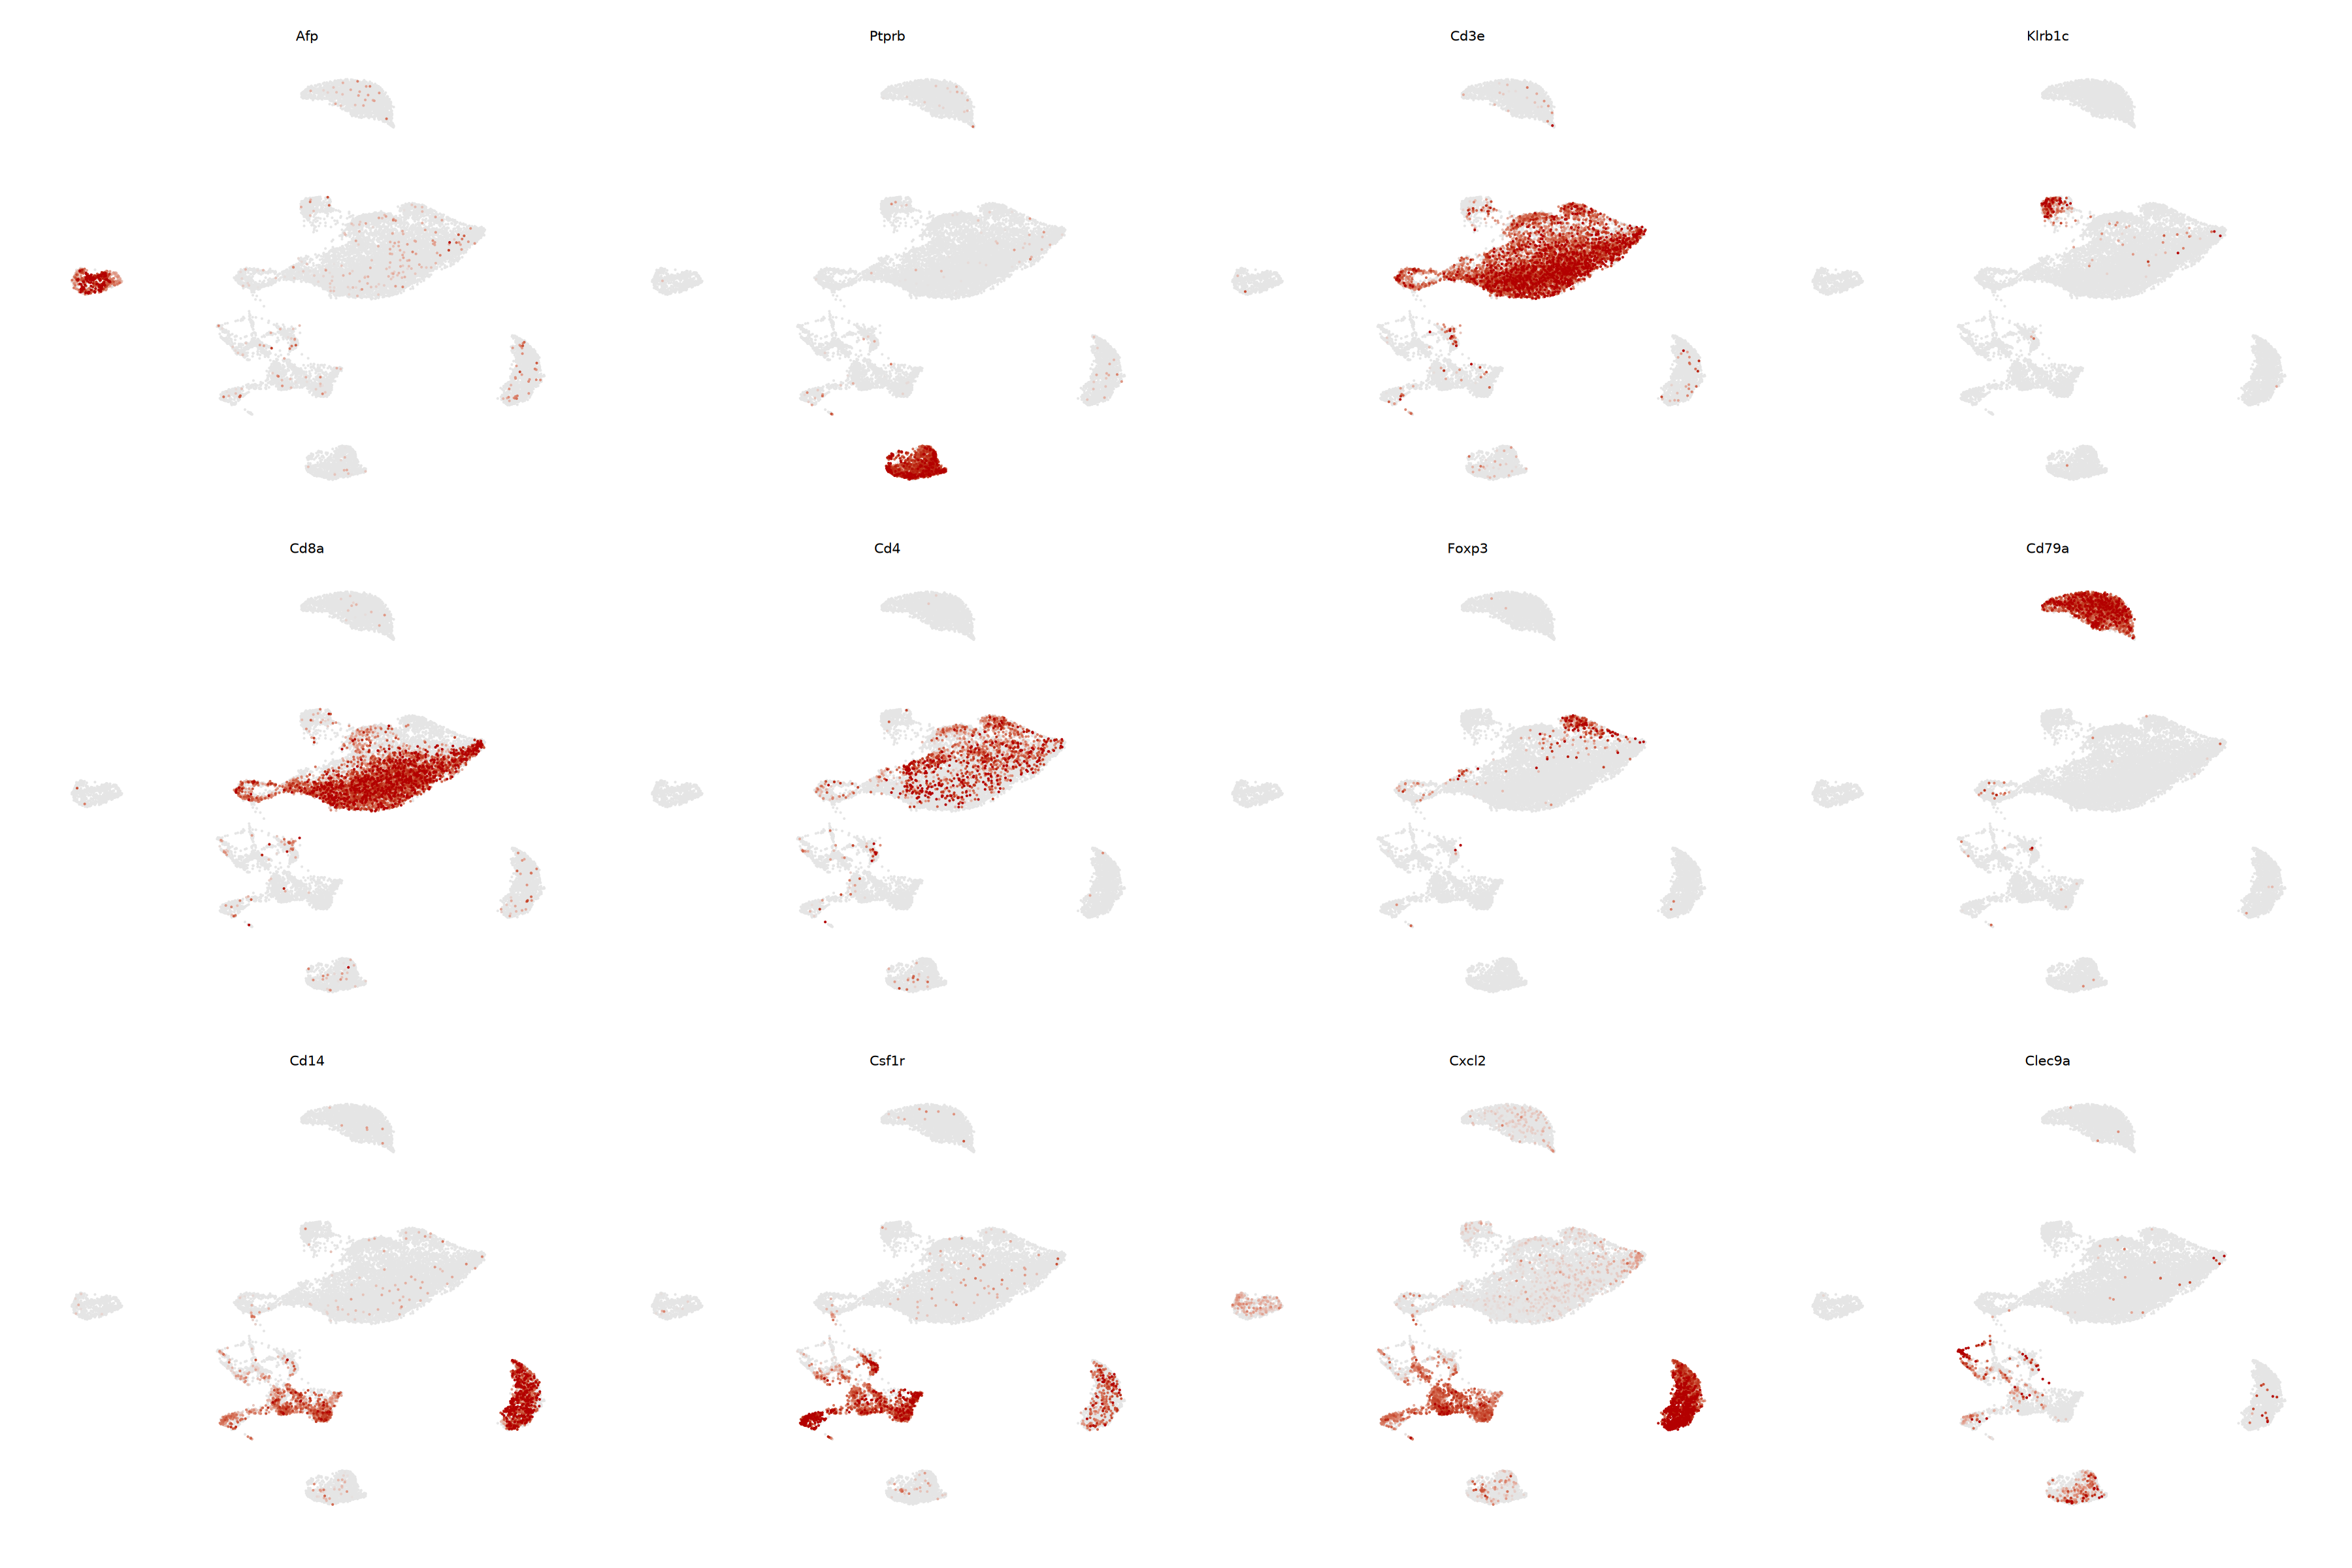

In [7]:
# 设置图形大小
options(repr.plot.width = 30, repr.plot.height = 20)

# 创建FeaturePlot
FeaturePlot(combined,
    features = c( "Afp", "Ptprb", "Cd3e","Klrb1c","Cd8a", "Cd4","Foxp3", "Cd79a","Cd14","Csf1r","Cxcl2","Clec9a"),
    ncol = 4,
    pt.size = 0.1,
    order = TRUE,
    reduction = "umap",
    cols = c("grey90", "#B30000"),
    min.cutoff = "q10",
    max.cutoff = "q90"
) &
theme_minimal() &
theme(
    plot.title = element_text(size = 12, face = "bold", hjust = 0.5),  # 标题居中
    strip.text = element_text(size = 12, face = "bold", hjust = 0.5),  # 分面标题居中
    axis.title = element_blank(),    # 移除轴标题
    axis.text = element_blank(),     # 移除轴文本
    axis.ticks = element_blank(),    # 移除轴刻度线
    legend.position = "none",        # 移除图例
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm")
)

In [8]:
cluster_mapping <- c(
  # T cells
  "0" = "T",  # 效应T细胞
  "1" = "T",  # CD8+ 细胞毒性T细胞
  "5" = "T",  # 调节性T细胞 (Tregs)
  "6" = "T",  # 初始/记忆T细胞
  "7" = "T",  # 增殖T细胞
  "8" = "T",  # CD4+ T细胞

  
  # B cells
  "2" = "B",  # B细胞
  
  # Neutrophils
  "3" = "Mono/Mac",  # Inflammatory Activated Macrophages
  
  # Endothelial cells
  "4" = "Endothelial",  # 内皮细胞
  
  # Macrophages/Monocytes
  "9" = "Mac",  # 巨噬细胞
  "11" = "Mono/Mac",  # 单核细胞
  "14" = "Mac",  # 激活型巨噬细胞
  "15" = "Mac",  # 组织驻留巨噬细胞
  
  # AFP+ cells
  "10" = "HCC",  
  
  # Dendritic cells
  "12" = "DC",  # 树突状细胞
  
  # NK cells
  "13" = "NK"  # 自然杀伤细胞
)
# 2. 设置聚类顺序和celltype
Idents(combined) <- combined$RNA_snn_res.0.6
cluster_order <- names(cluster_mapping)
combined$celltype <- plyr::mapvalues(
 Idents(combined),
 from = names(cluster_mapping),
 to = unname(cluster_mapping)
)

output_path <- "/data3/Group8/gonglihao/1-MMP9/3-Annotation"
saveRDS(combined, file = file.path(output_path, "anno-0.6.rds"))

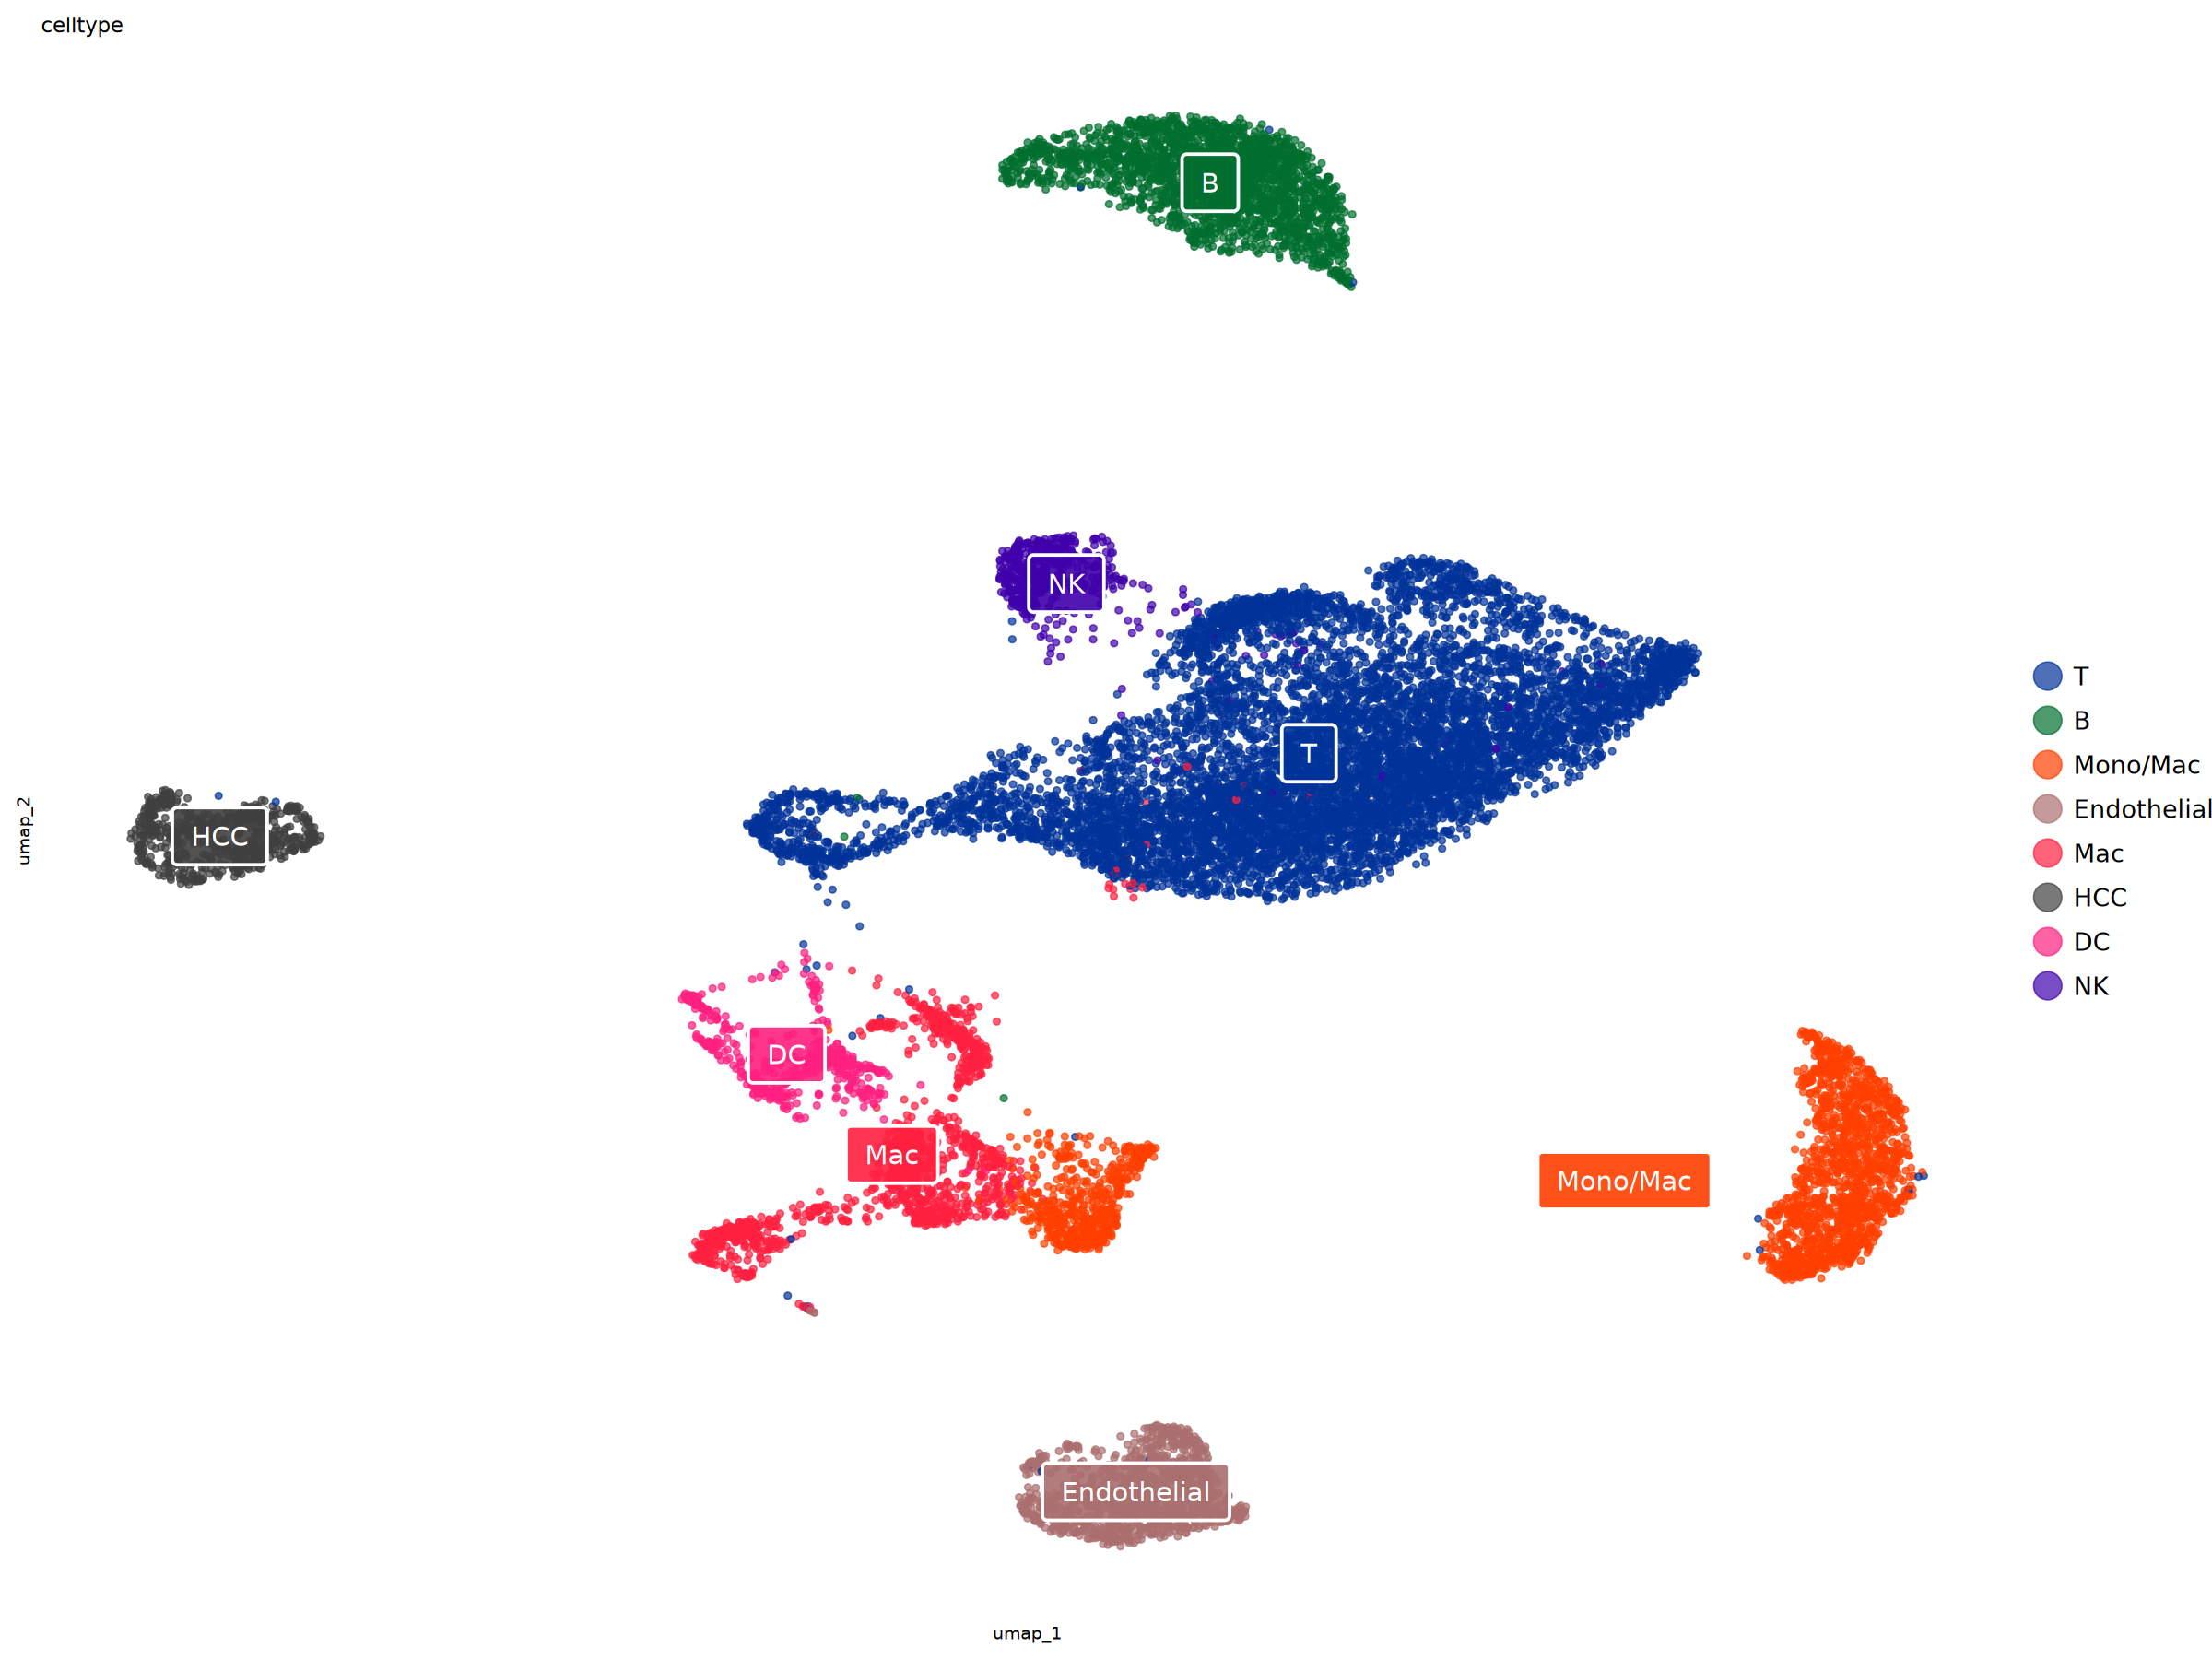

In [9]:
custom_colors <- c(
"T" = "#003399",
"B" = "#006E2E",
"Mono/Mac" = "#FF4000", 
"Mac" = "#FF2040",
"Endothelial" = "#aa6f6f",
"HCC" = "#404040",
"DC" = "#FF2080",
 "NK" = "#4000AA"    
)
# 4. 创建UMAP图
umap_coords <- as.data.frame(Embeddings(combined, "umap"))
umap_coords$celltype <- combined$celltype

# 计算中心点
cell_centers <- umap_coords %>%
  group_by(celltype) %>%
  summarise(
    umap_1 = mean(umap_1),
    umap_2 = mean(umap_2)
  )

p1 <- DimPlot(combined,
              reduction = "umap",
              group.by = "celltype",
              label = FALSE,
              cols = custom_colors,
              pt.size = 1.5,
              repel = TRUE,
              alpha = 0.7) +
   theme_minimal() +
   theme(
     legend.position = "right",
     legend.text = element_text(size = 16),
     legend.title = element_blank(),  # 移除图例标题
     legend.box = "vertical",  # 确保图例为垂直排列
     legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
     panel.grid = element_blank(),
     axis.text = element_blank()
   ) +
   guides(color = guide_legend(ncol = 1,override.aes = list(size = 8),keyheight = 2)) +  # 设置图例为单列
   # 添加带背景的标签
   geom_label(data = cell_centers,
              aes(x = umap_1,
                  y = umap_2,
                  label = celltype,
                  fill = celltype),
              color = "white",
              fontface = "bold",
              alpha = 0.9,
              size = 6,
              label.size = 0.8,
              label.padding = unit(0.6, "lines")) +
   scale_fill_manual(values = custom_colors,guide = "none")

# 显示图形
options(repr.plot.width = 20, repr.plot.height = 15)
print(p1)

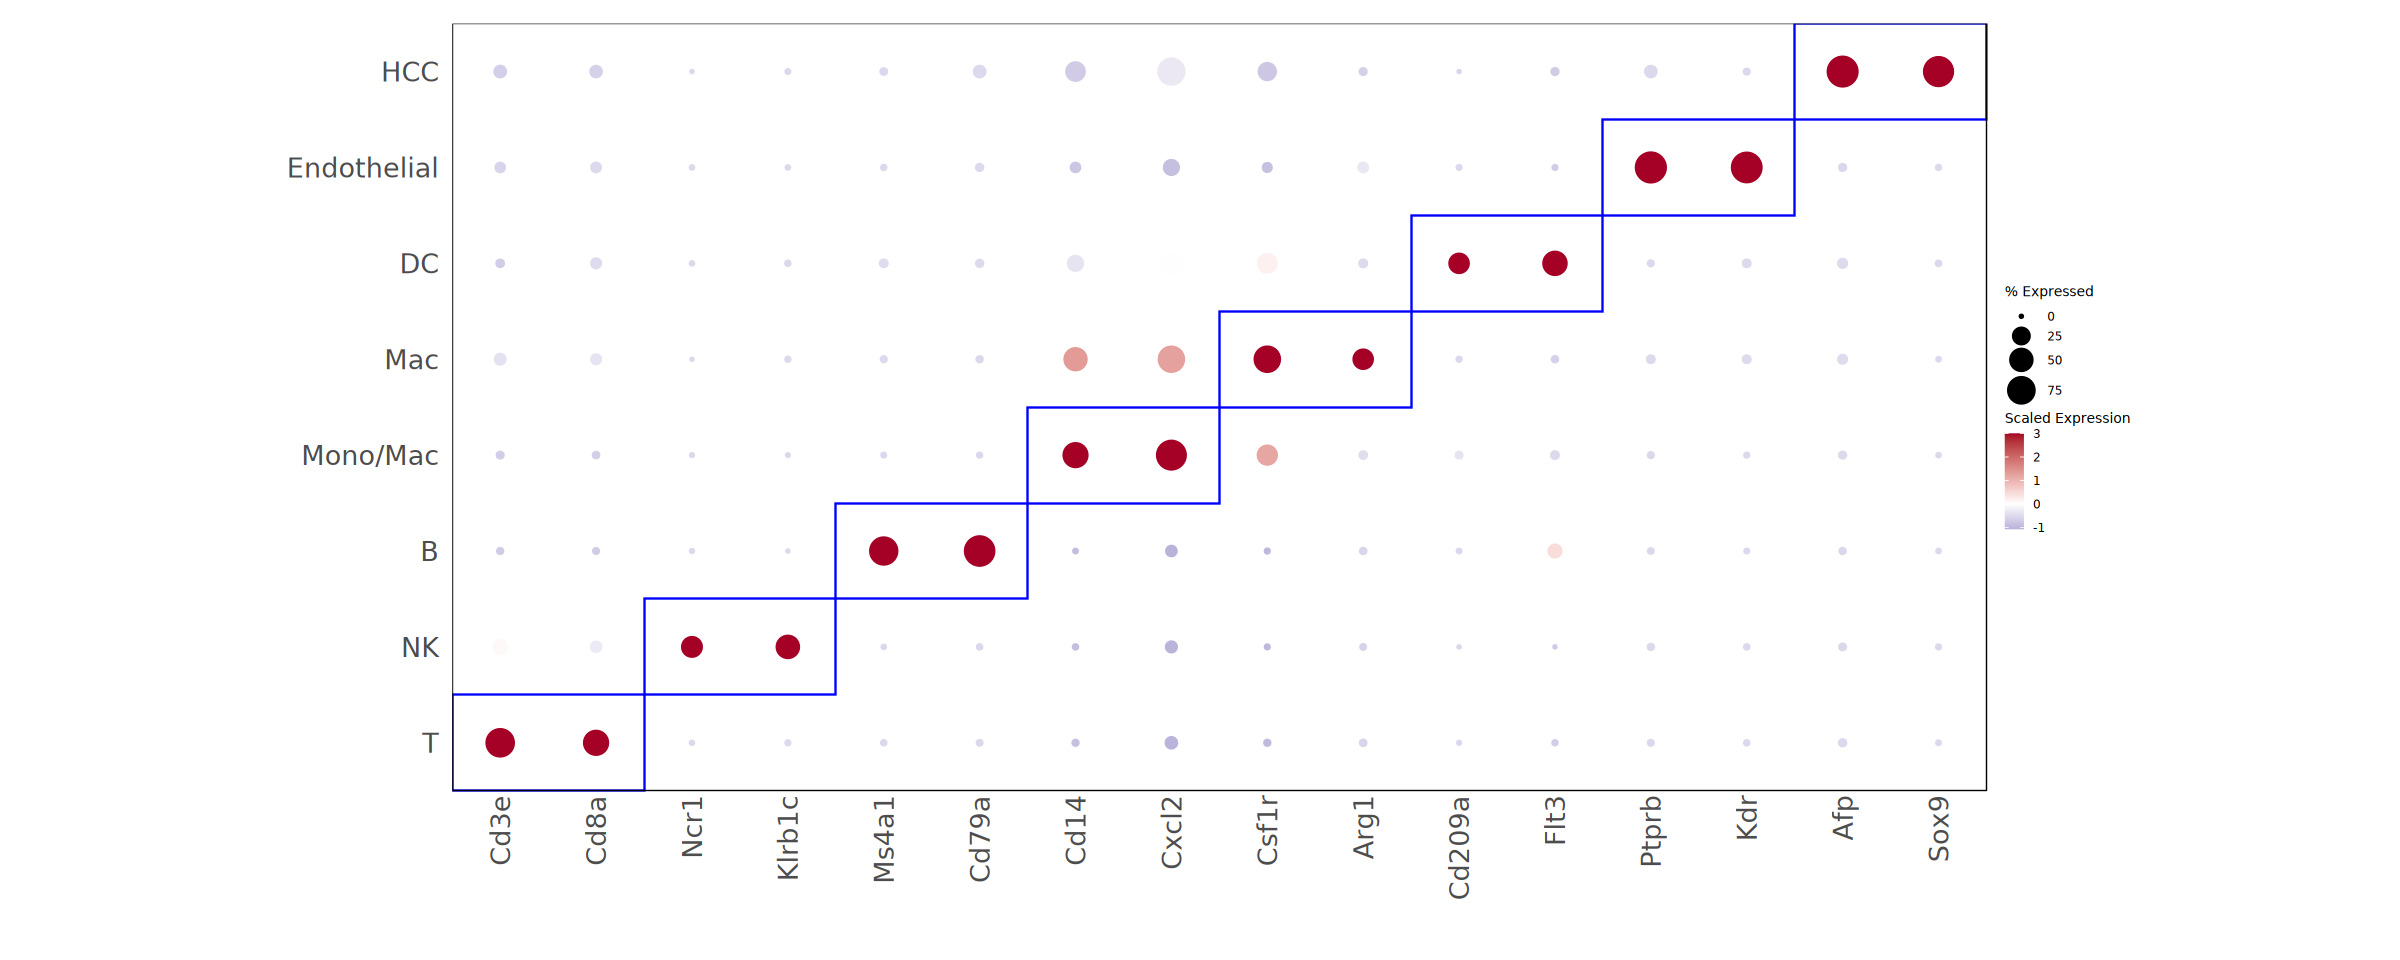

In [ ]:
custom_colors <- c(
"T" = "#003399",
"B" = "#006E2E",
"Mono/Mac" = "#FF4000", 
"Mac" = "#FF2040",
"Endothelial" = "#aa6f6f",
"HCC" = "#404040",
"DC" = "#FF2080",
 "NK" = "#4000AA"    
)


marker_genes <- list(
    # T cells
    "T" = c("Cd3e", "Cd8a"),
   
    # NK cells
    "NK" = c("Ncr1", "Klrb1c"),
    
    # B cells
    "B" = c("Ms4a1", "Cd79a"),

    "Mono/Mac" = c("Cd14","Cxcl2"),
    "Mac" = c("Csf1r","Arg1"),    
    "DC" = c("Cd209a", "Flt3"),

"Endothelial" = c("Ptprb", "Kdr"),
    "HCC" = c("Afp", "Sox9")
)
# 准备基因表达数据
genes <- unique(unlist(marker_genes))
genes <- genes[genes %in% rownames(combined)]

# 获取表达矩阵
expr_matrix <- GetAssayData(combined, assay = "RNA", layer = "data")[genes, ]

# 计算每个细胞类型的统计信息
cluster_stats <- lapply(names(marker_genes), function(celltype_name) {
    cells <- WhichCells(combined, expression = celltype == celltype_name)
    cluster_expr <- expr_matrix[, cells, drop = FALSE]
    data.frame(
        gene = genes,
        celltype = celltype_name,
        avg.exp = rowMeans(cluster_expr),
        pct.exp = rowMeans(cluster_expr > 0) * 100
    )
})

# 合并所有数据
plot_data <- do.call(rbind, cluster_stats)

# 计算标准化表达值
plot_data <- plot_data %>%
    group_by(gene) %>%
    mutate(
        avg.exp.scaled = (scale(avg.exp)[,1] * 1.5),
        avg.exp.scaled = pmin(pmax(avg.exp.scaled, -3), 3)
    ) %>%
    ungroup()

# 修改分组信息部分
plot_data$group <- NA
for(group_name in names(marker_genes)) {
    plot_data$group[plot_data$gene %in% marker_genes[[group_name]]] <- group_name
}

# 设置因子水平
celltype_order <- names(marker_genes)
plot_data$group <- factor(plot_data$group, levels = celltype_order)
plot_data$gene <- factor(plot_data$gene, levels = genes)
plot_data$celltype <- factor(plot_data$celltype, levels = celltype_order)

# 创建边框数据框
border_data <- data.frame()
for(ct in names(marker_genes)) {
    genes_in_group <- marker_genes[[ct]]
    gene_positions <- which(levels(plot_data$gene) %in% genes_in_group)
    ct_position <- which(levels(plot_data$celltype) == ct)
    
    if(length(gene_positions) > 0) {
        border_data <- rbind(border_data, data.frame(
            xmin = min(gene_positions) - 0.5,
            xmax = max(gene_positions) + 0.5,
            ymin = ct_position - 0.5,
            ymax = ct_position + 0.5
        ))
    }
}

# 创建图形
p <- ggplot(plot_data, aes(y = celltype, x = gene)) +
    # 添加边框
    geom_rect(data = border_data,
              aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
              fill = NA, color = "blue", linewidth = 0.5, inherit.aes = FALSE) +
    geom_point(aes(size = pct.exp, color = avg.exp.scaled)) +
    scale_color_gradient2(
        low = "#313695",
        mid = "#FFFFFF",
        high = "#A50026",
        midpoint = 0,
        space = "Lab",
        na.value = "grey50",
        guide = "colourbar"
    ) +
    scale_size(range = c(0.5, 8), breaks = c(0, 25, 50, 75, 100)) +
    theme_minimal() +
    theme(
        axis.text.x = element_text(
            angle = 90,
            hjust = 1,
            vjust = 0.5,
            size = 16,
            face = "bold",
            margin = margin(t = 0, r = 0, b = 0, l = 0)
        ),
        axis.text.y = element_text(
            size = 16,
            hjust = 1,
            margin = margin(t = 0, r = 5, b = 0, l = 0)
        ),
        panel.grid = element_blank(),
        plot.margin = unit(c(0.5, 1, 1, 1), "cm"),
        panel.border = element_rect(colour = "black", fill = NA, linewidth = 0.3),
        legend.position = "right",
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 7),
        legend.margin = margin(0, 0, 0, 0),
        legend.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.8, "lines")
    ) +
    labs(
        x = "",        # 空白x轴标签
        y = "",        # 空白y轴标签
        color = "Scaled Expression",
        size = "% Expressed"
    ) +
    coord_fixed(ratio = 1) +
    scale_x_discrete(expand = expansion(add = 0.5)) +
    scale_y_discrete(expand = expansion(add = 0.5))

# 调整输出图形尺寸
options(repr.plot.width = 20, repr.plot.height = 8)

# 打印图形
print(p)